# A Comparative Analysis of SVM and Random Forest Regressor for Temperature Prediction of Stockholm

### About the Data

The data we are analyzing is Stockholm Historical Weather Observations — Daily mean air temperatures since 1756.

The dataset contains historical daily temperature data for Stockholm, Sweden. Here's a simple description of the data columns:

1. **Date (yyyy-mm-dd)** `date` (Column 1):
   - This column represents the date in the format year-month-day. It indicates when the temperature measurements were taken.

2. **Non-Homogenized Daily Mean Temperature** `raw` (Column 2):
   - This column contains the daily mean temperature in degrees Celsius.
   - These values are based on direct observations and are not adjusted for various factors.

3. **Homogenized Daily Mean Temperature (Post-1870)** `homo` (Column 3):
   - This column also contains the daily mean temperature in degrees Celsius.
   - The temperatures here have been adjusted to account for the urban heat island effect, a phenomenon where urban areas are warmer than their rural surroundings.
   - Some early values in this column may have been infilled or estimated using data from Uppsala.

4. **Homogenized Daily Mean Temperature `adjust` (Pre-1859 with Summer Adjustment)** (Column 4):
   - Similar to Column 3, this column contains homogenized daily mean temperatures in degrees Celsius.
   - In addition to post-1870 adjustments, this column also includes extra adjustments for May to August temperatures before 1859. This adjustment corrects for a supposed warm bias in summer months.

5. **Data Source ID Code** `site`(Column 5):
   - This column contains an ID code that identifies the source of the temperature data.
   - The codes correspond to different sources:
     - (1) Stockholm, manual observations.
     - (2) Uppsala, adjusted to represent Stockholm.
     - (3) Stockholm, SMHI automatic weather station (used from 2013 onwards).
   - Data from Uppsala were used for a few short periods in 1756 and 1763 and only in the homogenized data in columns 3 and 4.

Additional Information:
- All temperature values are rounded to one decimal place (°C).
- Missing values in Column 2 are coded as -999.0.

In summary, this dataset provides a historical record of daily mean temperatures in Stockholm, Sweden, along with adjustments made to account for various factors affecting temperature measurements. It includes both raw and homogenized temperature data, making it suitable for studying temperature trends and variations over time in the region. The data also provides information about data sources and adjustments made to the measurements.

## Import Necessary Libraries:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load data:

In [2]:
data = pd.read_csv("https://bolin.su.se/data/data/stockholm_daily_mean_temperature.csv")

In [3]:
data.head()

,date,raw,homo,adjust,site
0,1756-01-01,-8.7,-8.7,-8.7,1
1,1756-01-02,-9.2,-9.2,-9.2,1
2,1756-01-03,-8.6,-8.6,-8.6,1
3,1756-01-04,-7.7,-7.7,-7.7,1
4,1756-01-05,-7.2,-7.2,-7.2,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97793 entries, 0 to 97792
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    97793 non-null  object 
 1   raw     97793 non-null  float64
 2   homo    97793 non-null  float64
 3   adjust  97793 non-null  float64
 4   site    97793 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 3.7+ MB


## Data Preprocessing & EDA:

In [5]:
# Parse dates
# Import data again but this time parse dates
df = pd.read_csv("https://bolin.su.se/data/data/stockholm_daily_mean_temperature.csv",
                 low_memory=False,
                 parse_dates=["date"])

In [6]:
# checking the format of date
df.info()
# It's changed to datetime format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97793 entries, 0 to 97792
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    97793 non-null  datetime64[ns]
 1   raw     97793 non-null  float64       
 2   homo    97793 non-null  float64       
 3   adjust  97793 non-null  float64       
 4   site    97793 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 3.7 MB


In [7]:
# Dropping column 4 - `site` since it is irrelevant
df.drop(df.columns[[4]], axis=1, inplace=True)
df.head()

,date,raw,homo,adjust
0,1756-01-01,-8.7,-8.7,-8.7
1,1756-01-02,-9.2,-9.2,-9.2
2,1756-01-03,-8.6,-8.6,-8.6
3,1756-01-04,-7.7,-7.7,-7.7
4,1756-01-05,-7.2,-7.2,-7.2


In [8]:
# Shape of the dataset
df.shape

(97793, 4)

In [9]:
# Replace missing values (-999.0) in Column 2 with NaN since it's mentioned that the missing values are represented by -999.0
df['raw'].replace(-999.0, float('nan'), inplace=True)

In [10]:
df.isna().sum()

date      0
raw       7
homo      0
adjust    0
dtype: int64

In [11]:
df.isnull().sum()

date      0
raw       7
homo      0
adjust    0
dtype: int64

In [12]:
# Drop rows of missing data
df.dropna(inplace=True)
print(df.isna().sum())
df.isnull().sum()

date      0
raw       0
homo      0
adjust    0
dtype: int64


date      0
raw       0
homo      0
adjust    0
dtype: int64

In [13]:
df.shape

(97786, 4)

In [14]:
# Checking if there are any duplicates
df.duplicated().sum()

0

## Exploratory Data Analysis:

In [15]:
df.describe()

# Since most of the values of 3 columns look similar, Very less chance of having outliers

,raw,homo,adjust
count,97786.000000,97786.000000,97786.000000
mean,6.258988,5.929777,5.865216
std,8.386411,8.346944,8.275338
min,-27.700000,-27.700000,-27.700000
25%,0.200000,-0.100000,-0.100000
50%,5.800000,5.500000,5.500000
75%,13.400000,13.000000,12.900000
max,28.300000,27.500000,27.500000


C:\Users\reeth\AppData\Local\Temp\ipykernel_9680\1565657869.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  temp_corr_matrix = df.corr()


             raw      homo    adjust
raw     1.000000  0.998883  0.998936
homo    0.998883  1.000000  0.999779
adjust  0.998936  0.999779  1.000000


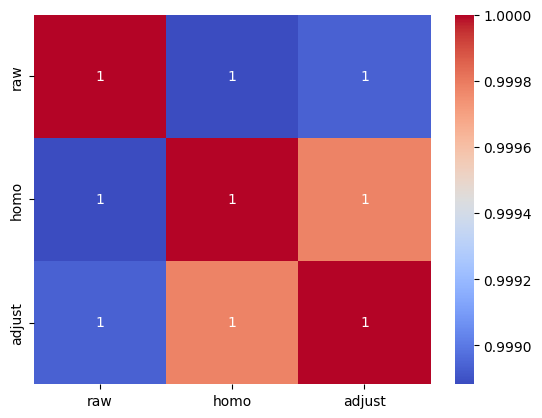

In [16]:
# Checking for correlation between the columns
# Creating the correlation matrix of the dataset
temp_corr_matrix = df.corr()
print(temp_corr_matrix)

# Create the heatmap using the `heatmap` function of Seaborn
sns.heatmap(temp_corr_matrix, cmap='coolwarm', annot=True)

# Display the heatmap using the `show` method of the `pyplot` module from matplotlib.
plt.show()

In [17]:
df.head()

,date,raw,homo,adjust
0,1756-01-01,-8.7,-8.7,-8.7
1,1756-01-02,-9.2,-9.2,-9.2
2,1756-01-03,-8.6,-8.6,-8.6
3,1756-01-04,-7.7,-7.7,-7.7
4,1756-01-05,-7.2,-7.2,-7.2


In [18]:
# There is very high correlation between raw, adjust and homo columns. We can drop raw and adjust columns
df.drop("raw", axis=1, inplace=True)
df.drop("adjust", axis=1, inplace=True)

In [19]:
df.head()

,date,homo
0,1756-01-01,-8.7
1,1756-01-02,-9.2
2,1756-01-03,-8.6
3,1756-01-04,-7.7
4,1756-01-05,-7.2


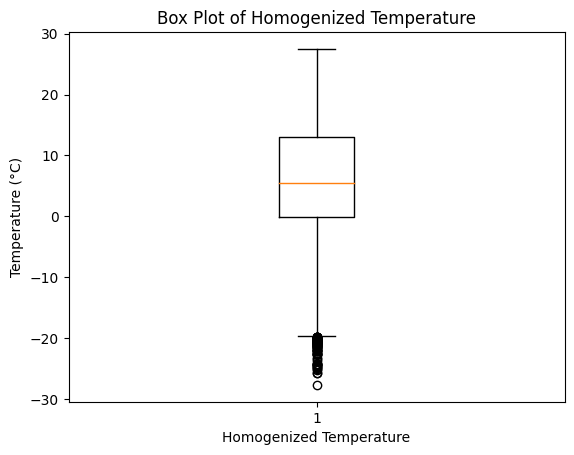

In [20]:
# Check for outliers in homo column
# Create a box plot for homo column
plt.boxplot(df['homo'])
plt.xlabel('Homogenized Temperature')
plt.ylabel('Temperature (°C)')
plt.title('Box Plot of Homogenized Temperature')
plt.show()

# No outliers

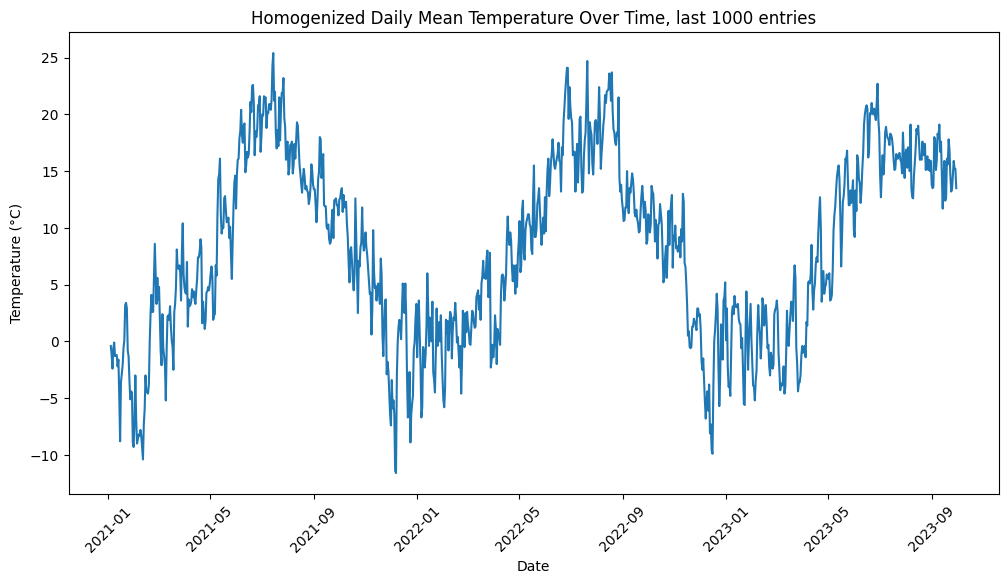

In [21]:
# Data visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='homo', data=df[-1000:])
plt.title('Homogenized Daily Mean Temperature Over Time, last 1000 entries')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

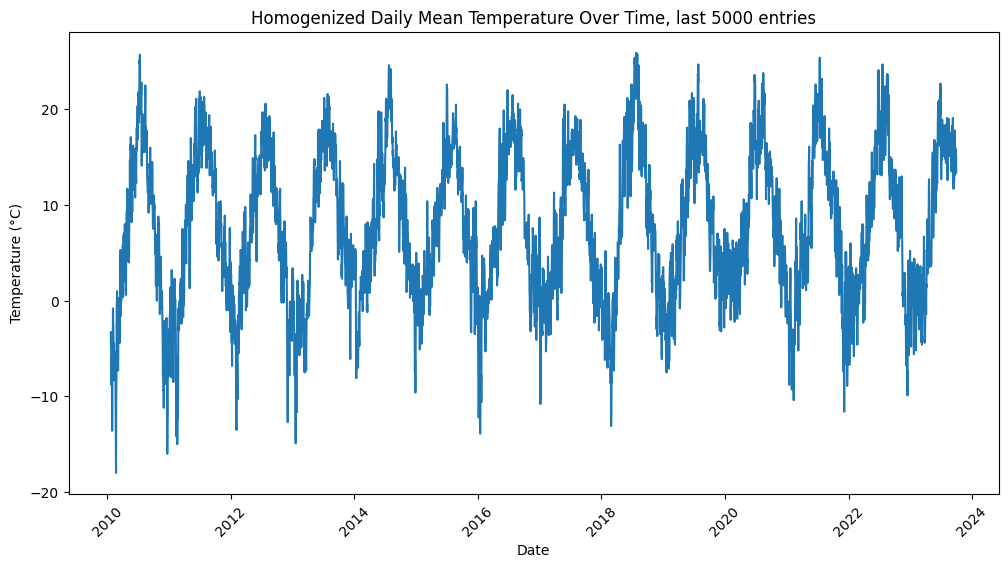

In [22]:
# Data visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='homo', data=df[-5000:])
plt.title('Homogenized Daily Mean Temperature Over Time, last 5000 entries')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

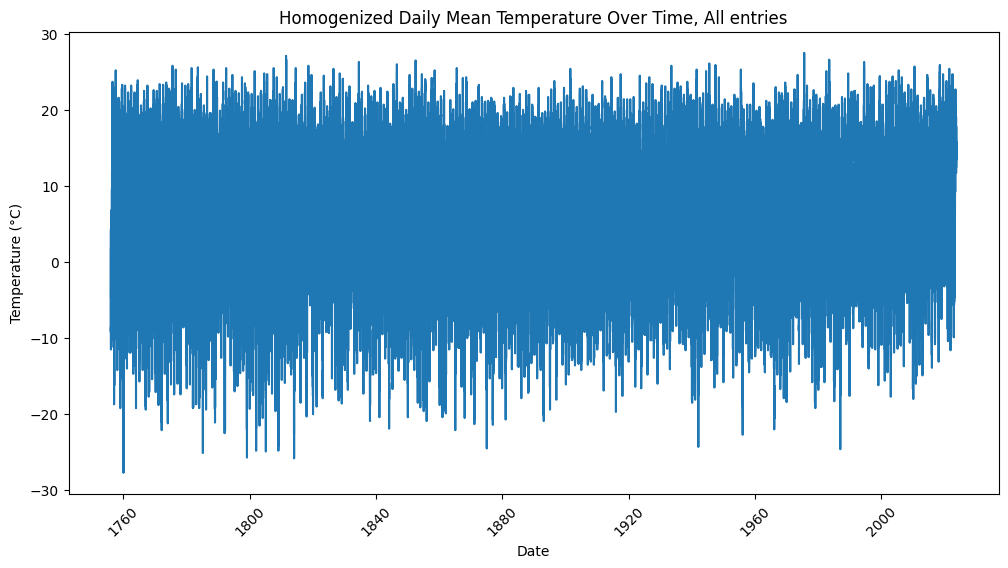

In [23]:
# Data visualization
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='homo', data=df)
plt.title('Homogenized Daily Mean Temperature Over Time, All entries')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.show()

#### Add datetime parameters for `date` column

In [24]:
# Make new df 
# Let's consider the data only from 1990 to reduce the runtime
df_new = df[df['date'].dt.year >= 1990]
df_new.reset_index(inplace=True)
df_new.head

<bound method NDFrame.head of        index       date  homo
0      85467 1990-01-01  -3.6
1      85468 1990-01-02  -5.0
2      85469 1990-01-03  -4.3
3      85470 1990-01-04  -0.9
4      85471 1990-01-05  -1.1
...      ...        ...   ...
12321  97788 2023-09-26  14.7
12322  97789 2023-09-27  15.9
12323  97790 2023-09-28  15.2
12324  97791 2023-09-29  15.2
12325  97792 2023-09-30  13.5

[12326 rows x 3 columns]>

In [25]:
df_new.drop("index", axis=1, inplace=True)
df_new.head()

C:\Users\reeth\AppData\Local\Temp\ipykernel_9680\2528147632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop("index", axis=1, inplace=True)


,date,homo
0,1990-01-01,-3.6
1,1990-01-02,-5.0
2,1990-01-03,-4.3
3,1990-01-04,-0.9
4,1990-01-05,-1.1


In [26]:
df_new["year"] = df_new.date.dt.year
df_new["month"] = df_new.date.dt.month
df_new["day"] = df_new.date.dt.day
df_new["dayOfWeek"] = df_new.date.dt.dayofweek
df_new["dayOfYear"] = df_new.date.dt.dayofyear

C:\Users\reeth\AppData\Local\Temp\ipykernel_9680\1407986688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["year"] = df_new.date.dt.year
C:\Users\reeth\AppData\Local\Temp\ipykernel_9680\1407986688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["month"] = df_new.date.dt.month
C:\Users\reeth\AppData\Local\Temp\ipykernel_9680\1407986688.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [27]:
df_new.head()

,date,homo,year,month,day,dayOfWeek,dayOfYear
0,1990-01-01,-3.6,1990,1,1,0,1
1,1990-01-02,-5.0,1990,1,2,1,2
2,1990-01-03,-4.3,1990,1,3,2,3
3,1990-01-04,-0.9,1990,1,4,3,4
4,1990-01-05,-1.1,1990,1,5,4,5


In [28]:
df_new.tail()

,date,homo,year,month,day,dayOfWeek,dayOfYear
12321,2023-09-26,14.7,2023,9,26,1,269
12322,2023-09-27,15.9,2023,9,27,2,270
12323,2023-09-28,15.2,2023,9,28,3,271
12324,2023-09-29,15.2,2023,9,29,4,272
12325,2023-09-30,13.5,2023,9,30,5,273


In [29]:
# Now we've enriched our DataFrame with date time features, we can remove 'date' column
df_new.drop("date", axis=1, inplace=True)

C:\Users\reeth\AppData\Local\Temp\ipykernel_9680\4176179770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop("date", axis=1, inplace=True)


In [30]:
df_new.head()

,homo,year,month,day,dayOfWeek,dayOfYear
0,-3.6,1990,1,1,0,1
1,-5.0,1990,1,2,1,2
2,-4.3,1990,1,3,2,3
3,-0.9,1990,1,4,3,4
4,-1.1,1990,1,5,4,5


## Modelling:

### Dividing the data in X, y and Train, test datasets:

In [31]:
# Dividing the data set into X, y and train split datasets
# Split data into X and y
X = df_new.drop("homo", axis=1)
y = df_new["homo"]

In [32]:
X

,year,month,day,dayOfWeek,dayOfYear
0,1990,1,1,0,1
1,1990,1,2,1,2
2,1990,1,3,2,3
3,1990,1,4,3,4
4,1990,1,5,4,5
...,...,...,...,...,...
12321,2023,9,26,1,269
12322,2023,9,27,2,270
12323,2023,9,28,3,271
12324,2023,9,29,4,272


In [33]:
y

0        -3.6
1        -5.0
2        -4.3
3        -0.9
4        -1.1
         ... 
12321    14.7
12322    15.9
12323    15.2
12324    15.2
12325    13.5
Name: homo, Length: 12326, dtype: float64

In [34]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

In [35]:
# Split data into train and test sets
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9860, 5), (9860,), (2466, 5), (2466,))

In [37]:
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 9860 entries, 286 to 7270
Series name: homo
Non-Null Count  Dtype  
--------------  -----  
9860 non-null   float64
dtypes: float64(1)
memory usage: 154.1 KB


In [38]:
X_train.head()

,year,month,day,dayOfWeek,dayOfYear
286,1990,10,14,6,287
8813,2014,2,17,0,48
9927,2017,3,7,1,66
1758,1994,10,25,1,298
5430,2004,11,13,5,318


### Working with SVM (SVR):

In [39]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [40]:
# Initializing the SVR model with all the 3 kernels
svr_rbf = SVR(kernel="rbf")

In [41]:
# Fitting the train data to the model
svr_rbf.fit(X_train, y_train)

SVR()

In [42]:
# Predicting values for X_test
y_pred_svr = svr_rbf.predict(X_test)
y_pred_svr

array([10.14859068,  8.90333905,  6.40047136, ...,  4.0336403 ,
        9.96241902, 10.11776972])

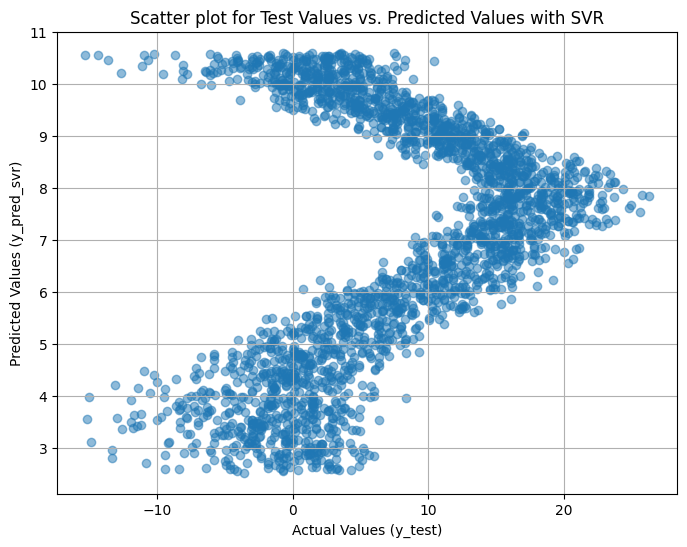

In [43]:
# Plotting the results (Actual values vs Predicted values)
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred_svr)")
plt.title("Scatter plot for Test Values vs. Predicted Values with SVR")
plt.grid(True)
plt.show()

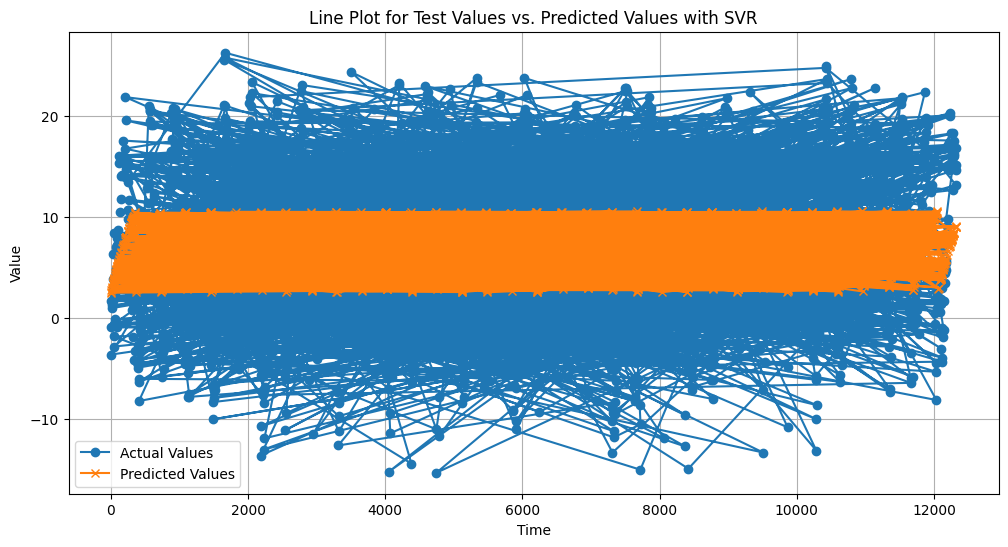

In [44]:
# Plotting the results (Actual values vs Predicted values)
# Line plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Values", marker='o')
plt.plot(y_test.index, y_pred_svr, label="Predicted Values", marker='x')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Line Plot for Test Values vs. Predicted Values with SVR")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Calculate regression metrics
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Evaluation metrics for SVR model:")
print("--------------------------------")
print(f"Mean Absolute Error: {round(mae_svr,2)}")
print(f"Mean Squared Error: {round(mse_svr,2)}")
print(f"Root Mean Squared Error: {round(rmse_svr,2)}")
print(f"R-squared (R2) Score: {round(r2_svr,2)}")

Evaluation metrics for SVR model:
--------------------------------
Mean Absolute Error: 6.07
Mean Squared Error: 53.43
Root Mean Squared Error: 7.31
R-squared (R2) Score: 0.11


#### Hyperparameter tuning of SVR_rbf using GridSearch:

In [64]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 1]
}

# Create the SVR model with RBF kernel
svr_rbf = SVR(kernel='rbf')

# Create GridSearchCV
grid_search = GridSearchCV(estimator=svr_rbf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_svr_rbf = grid_search.best_params_
best_svr_rbf = grid_search.best_estimator_

# Evaluate the best model on your test data
y_pred_svr = best_svr_rbf.predict(X_test)

In [65]:
best_params_svr_rbf, best_svr_rbf

({'C': 10, 'epsilon': 1, 'gamma': 0.01}, SVR(C=10, epsilon=1, gamma=0.01))

In [66]:
# Calculate regression metrics after Hyperparameter tuning
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Evaluation metrics for SVR model:")
print("--------------------------------")
print(f"Mean Absolute Error: {round(mae_svr,2)}")
print(f"Mean Squared Error: {round(mse_svr,2)}")
print(f"Root Mean Squared Error: {round(rmse_svr,2)}")
print(f"R-squared (R2) Score: {round(r2_svr,2)}")

Evaluation metrics for SVR model:
--------------------------------
Mean Absolute Error: 2.65
Mean Squared Error: 11.66
Root Mean Squared Error: 3.41
R-squared (R2) Score: 0.81


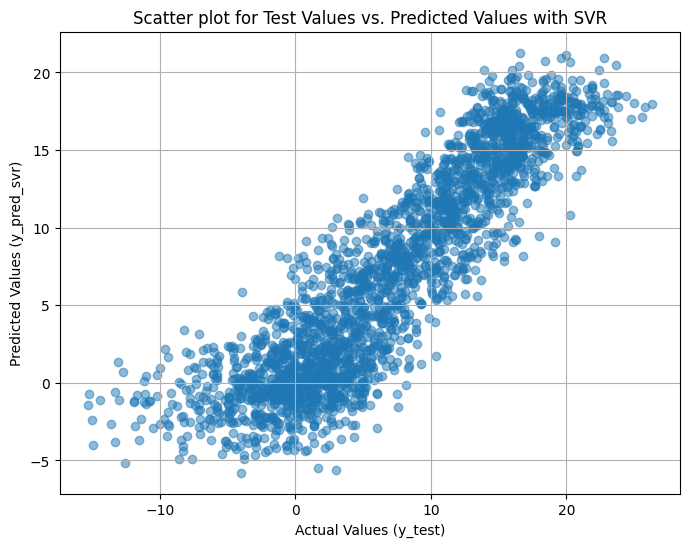

In [68]:
# Plotting the results (Actual values vs Predicted values) after Hyperparameter tuning
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred_svr)")
plt.title("Scatter plot for Test Values vs. Predicted Values with SVR")
plt.grid(True)
plt.show()

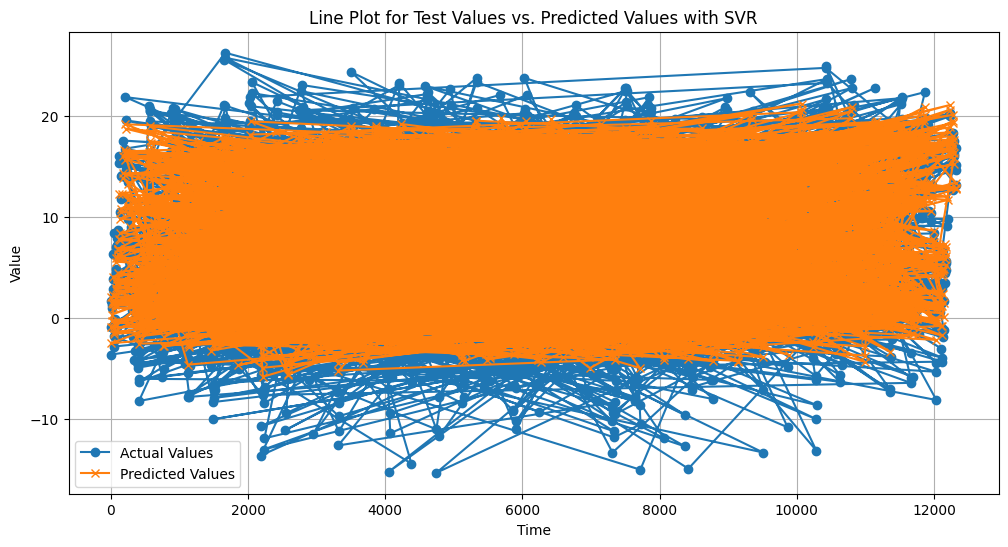

In [67]:
# Plotting the results (Actual values vs Predicted values) after Hyperparameter tuning
# Line plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Values", marker='o')
plt.plot(y_test.index, y_pred_svr, label="Predicted Values", marker='x')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Line Plot for Test Values vs. Predicted Values with SVR")
plt.legend()
plt.grid(True)
plt.show()

### Working with RandomForestRegressor:

In [54]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# Fit the model
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [55]:
# Make predictions
y_pred_rf = model.predict(X_test)
y_pred_rf.shape, y_pred_rf

((2466,), array([ 0.738, 10.704, 12.392, ..., -0.046,  0.909,  3.406]))

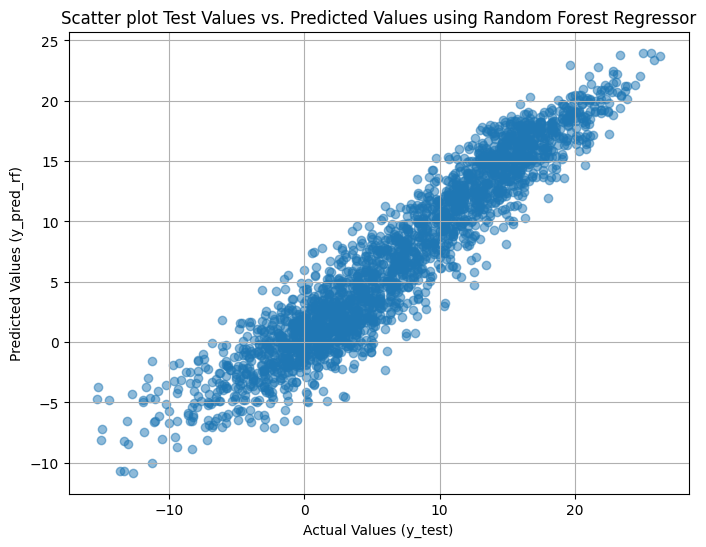

In [57]:
# Plotting the results (Actual values vs Predicted values)
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred_rf)")
plt.title("Scatter plot Test Values vs. Predicted Values using Random Forest Regressor")
plt.grid(True)
plt.show()

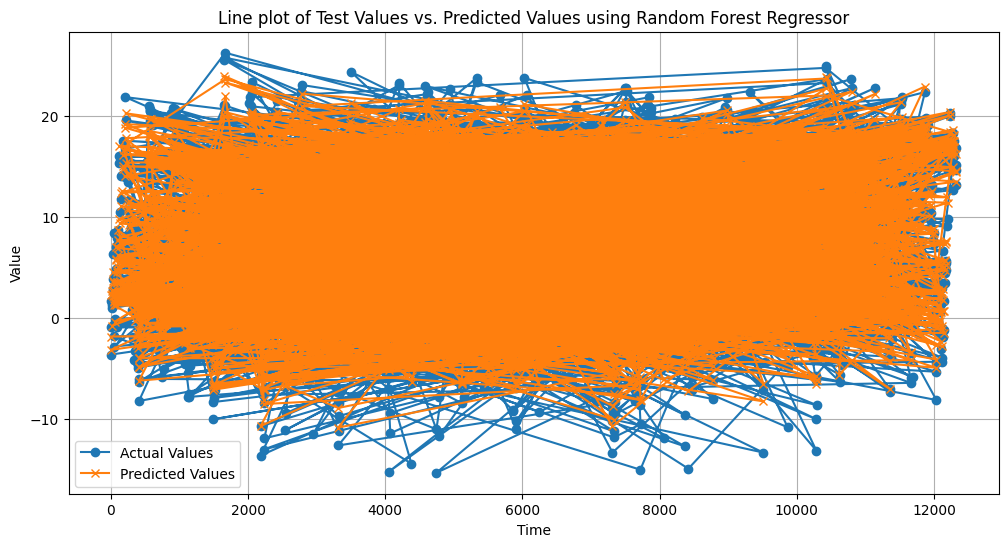

In [58]:
# Plotting the results (Actual values vs Predicted values)
# Line plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Values", marker='o')
plt.plot(y_test.index, y_pred_rf, label="Predicted Values", marker='x')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Line plot of Test Values vs. Predicted Values using Random Forest Regressor")
plt.legend()
plt.grid(True)
plt.show()

In [59]:
# Calculate regression metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Evaluation metrics for RandomForestRegressor:")
print("----------------------------------------------")
print(f"Mean Absolute Error: {round(mae_rf,2)}")
print(f"Mean Squared Error: {round(mse_rf,2)}")
print(f"Root Mean Squared Error: {round(rmse_rf,2)}")
print(f"R-squared (R2) Score: {round(r2_rf,2)}")

Evaluation metrics for RandomForestRegressor:
----------------------------------------------
Mean Absolute Error: 1.89
Mean Squared Error: 5.92
Root Mean Squared Error: 2.43
R-squared (R2) Score: 0.9


#### Hyperparameter Tuning for RandomForestRegressor using GridSearch:

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],         # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],         # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],         # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]            # Minimum samples required at each leaf node
}

# Create the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Create GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Evaluate the best model on your test data
y_pred_rf = best_rf.predict(X_test)

In [61]:
best_params

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

In [62]:
# Calculate regression metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Evaluation metrics for RandomForestRegressor after Hyperparameter tuning:")
print("----------------------------------------------")
print(f"Mean Absolute Error: {round(mae_rf,2)}")
print(f"Mean Squared Error: {round(mse_rf,2)}")
print(f"Root Mean Squared Error: {round(rmse_rf,2)}")
print(f"R-squared (R2) Score: {round(r2_rf,2)}")

Evaluation metrics for RandomForestRegressor after Hyperparameter tuning:
----------------------------------------------
Mean Absolute Error: 1.89
Mean Squared Error: 5.91
Root Mean Squared Error: 2.43
R-squared (R2) Score: 0.9


### Comparing the Results:

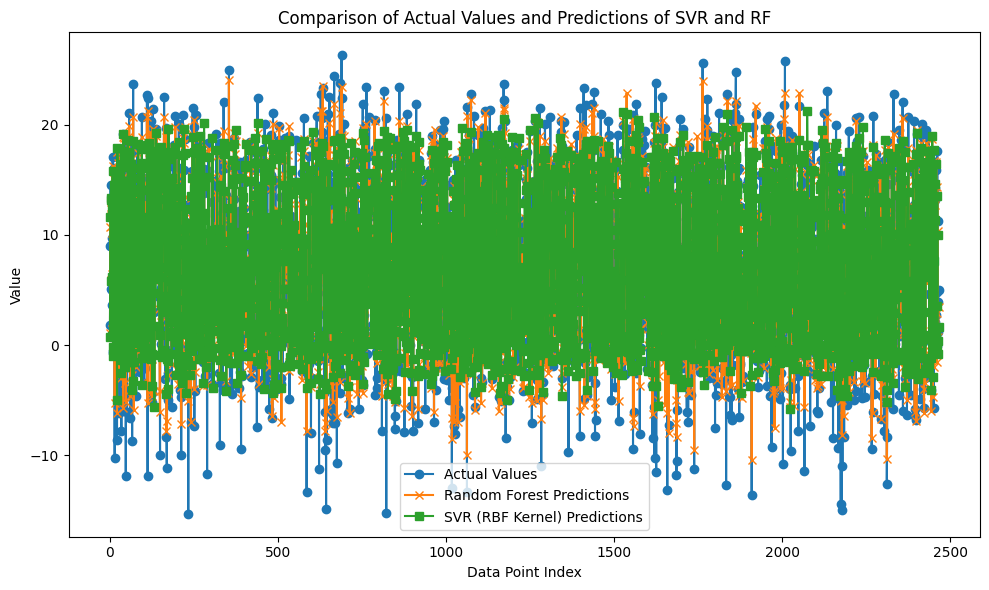

In [76]:
# Create an array for the x-axis (indices or a sequence)
x_indices = np.arange(len(y_test))

# Create a line plot to compare the values
plt.figure(figsize=(10, 6))
plt.plot(x_indices, y_test, label='Actual Values', marker='o')
plt.plot(x_indices, y_pred_rf, label='Random Forest Predictions', marker='x')
plt.plot(x_indices, y_pred_svr, label='SVR (RBF Kernel) Predictions', marker='s')

# Add labels, title, and legend
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.title('Comparison of Actual Values and Predictions of SVR and RF')
plt.legend()

plt.tight_layout()
plt.show()


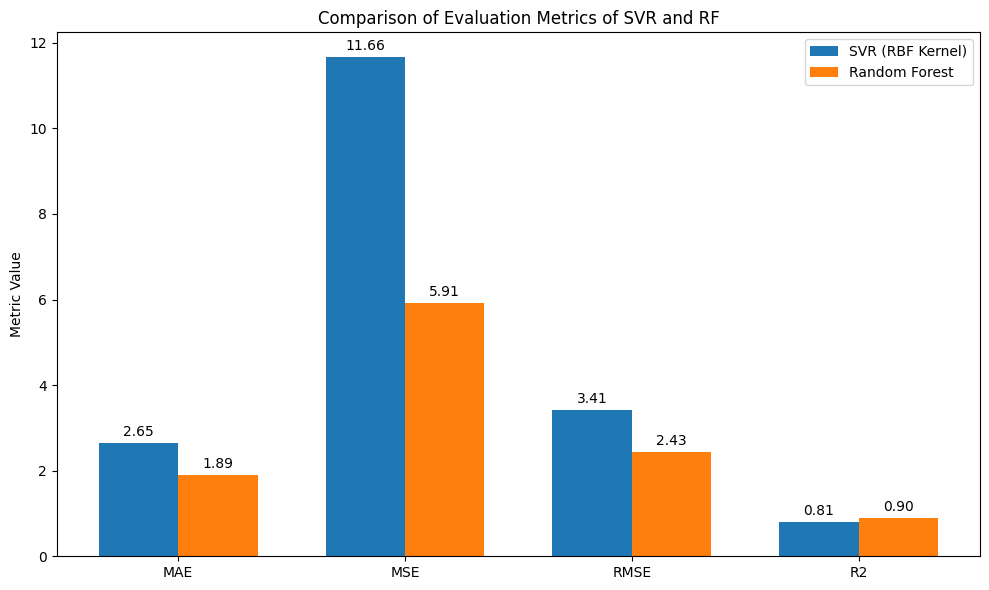

In [73]:
# Comparing Evaluation metrics of both models

# Define the evaluation metrics for both models
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
svr_metrics = [mae_svr, mse_svr, rmse_svr, r2_svr]
rf_metrics = [mae_rf, mse_rf, rmse_rf, r2_rf]

# Create a bar chart to compare metrics
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, svr_metrics, width, label='SVR (RBF Kernel)')
rects2 = ax.bar(x + width/2, rf_metrics, width, label='Random Forest')

# Add labels, title, and legend
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Evaluation Metrics of SVR and RF')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the metric values on top of the bars
def add_value_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

add_value_labels(rects1)
add_value_labels(rects2)

plt.tight_layout()
plt.show()
